In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import dataframe_image as dfi
import seaborn as sns 
import numpy as np 

import os
import pickle
from IPython.display import display_html 

from typing import List, Dict, Any, Optional

# ignore warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# Models
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC # , SVC
from sklearn.naive_bayes import MultinomialNB

## Pre-Processing
from sklearn.model_selection import train_test_split, KFold, cross_val_score #train/test split & k-fold cross validation
from sklearn.preprocessing import MinMaxScaler #scaler
from sklearn.decomposition import PCA #principle component analysis
from sklearn.impute import KNNImputer #impute missing data
from sklearn.inspection import permutation_importance

## Scoring 
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Data Import 
path = '/Users/rschraeder/Desktop/Projects/StanleyCupPredictions/data/'
classification_df = pd.read_csv(os.path.join(path, 'new_encoded_variables.csv'))
# test_df = pd.read_csv(os.path.join(path, 'encoded_variables.csv'))
games_df = pd.read_csv(os.path.join(path, 'regular_season_clean.csv'))
team_stats_df = pd.read_csv(os.path.join(path, 'team_stats_updated.csv'))
categorical_df = pd.read_csv(os.path.join(path, 'categorical_teams_set_cup.csv'))


In [2]:
# Game Outcome Predictors 

x = classification_df.loc[:, (classification_df.columns != 'away_outcome') & (classification_df.columns != 'home_outcome')]
y_away = classification_df['away_outcome'] # predicting away wins
y_home = classification_df['home_outcome'] # predicting home wins

# Impute missing values 
# imputer = KNNImputer(n_neighbors=2)
# x = imputer.fit_transform(x)
# y_away = imputer.fit_transform(y_away)
# y_home = imputer.fit_transform(y_home)

# Creating the Train and Test Split

# Use a train and test split for initial training & testing
x_away_train, x_away_test, y_away_train, y_away_test = train_test_split(x, y_away, test_size=0.30, random_state=42, shuffle=True)
x_home_train, x_home_test, y_home_train, y_home_test = train_test_split(x, y_home, test_size=0.30, random_state=42, shuffle=True)

In [3]:
# Building, Training, and Testing the Model Stack

class model_development: 
        
    def __init__(self, model, predictors, target): 
        self.model = model
        self.predictors = predictors
        self.target = target 
    
    
    def ensemble(names: List[str], models: List) -> Dict[str, Any]: 
        """ Creates a dictionary with each model name and the model associated """
        models = {names[i]: models[i] for i in range(len(names))}
        return models
    

    def evaluate_ensemble(models, x_train, y_train, x_test, y_test) -> Dict[str, Any]:
        """ 
        1) Conducts PCA for feature selection and k-fold cross-validation on each model 
        2) Evaluates each model with accuracy, precision, and recall scores and returns all average scores 
        """
        
        # Conduct PCA
        pca = PCA(n_components=10)
        pca.fit_transform(x_train, y_train)
        
        # Cross Validation 
        global cv 
        cv = KFold(n_splits=5, random_state=0, shuffle=True)
        
        
        train_scores = {
            names: 
                {
                    'Accuracy': cross_val_score(models, x_train, y_train, scoring='accuracy', cv=cv).mean(), 
                    'Precision': cross_val_score(models, x_train, y_train, scoring='precision', cv=cv).mean(), 
                    'Recall': cross_val_score(models, x_train, y_train, scoring='recall', cv=cv).mean()   
                }
             for (names, models) in models.items()
        }
        
        test_scores = {
            names: 
                {
                    'Accuracy': cross_val_score(models, x_test, y_test, scoring='accuracy', cv=cv).mean(), 
                    'Precision': cross_val_score(models, x_test, y_test, scoring='precision', cv=cv).mean(), 
                    'Recall': cross_val_score(models, x_test, y_test, scoring='recall', cv=cv).mean()   
                }
             for (names, models) in models.items()
        }

        return train_scores, test_scores
       
        
    def predict(model, x_test): 
        predictions = model.predict(x_test)
        return predictions
    

    def stacking_model(
        estimators: List[Any],
        final_estimator, 
        x_train,
        y_train,
        x_test,
        y_test, 
        n_folds
    ):

        stack = StackingClassifier(estimators, final_estimator, stack_method='auto')
        stack = stack.fit(x_train, y_train)
        
        # Cross Validation 
        cv = KFold(n_folds, random_state=0, shuffle=True)
        
        return stack
        
    def evaluate_stack(stack, x_train, y_train): 
        
        # Cross Validation 
        cv = KFold(10, random_state=0, shuffle=True)
        
        result = [ 
            cross_val_score(stack, x_train, y_train, scoring='accuracy', cv=cv).mean(),
            cross_val_score(stack, x_train, y_train, scoring='precision', cv=cv).mean(),
            cross_val_score(stack, x_train, y_train, scoring='recall', cv=cv).mean(),
        ]
        
        return result
        
## Pass in the models we wish to stack 

models = model_development.ensemble(
    names =  ['logistic_regression', 'bayes'],
    models =  [
        LogisticRegression(),
        make_pipeline(MinMaxScaler(), MultinomialNB()),
    ]
)
models_list = list(models.items())
models_list

[('logistic_regression', LogisticRegression()),
 ('bayes',
  Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                  ('multinomialnb', MultinomialNB())]))]

### Ensemble Performance

In [4]:
## Process, Train, Evaluate

# AWAY 
away_summary = model_development.evaluate_ensemble(models, x_away_train, y_away_train, x_away_test, y_away_test)
away_train_summary = pd.DataFrame.from_records(away_summary[0])
away_test_summary = pd.DataFrame.from_records(away_summary[1])

# HOME
home_summary = model_development.evaluate_ensemble(models, x_home_train, y_home_train, x_home_test, y_home_test)
home_train_summary = pd.DataFrame.from_records(home_summary[0])
home_test_summary = pd.DataFrame.from_records(home_summary[1])

def styler(df1, df2):
    """ SOURCE: https://www.thiscodeworks.com/display-two-dataframes-side-by-side-html-pandas-python-visualization/619285b06f88d700157a60d7 """
    
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Training Scores')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Testing Scores')
    return display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

### Away

In [5]:
styler(away_train_summary, away_test_summary)

,bayes,logistic_regression
Accuracy,0.737521,0.998913
Precision,0.773939,0.997701
Recall,0.623032,1.000000
,bayes,logistic_regression
Accuracy,0.749747,1.000000
Precision,0.753239,1.000000
Recall,0.696348,1.000000


### Home

In [6]:
styler(home_train_summary, home_test_summary)

,bayes,logistic_regression
Accuracy,0.737521,0.998913
Precision,0.724275,1.000000
Recall,0.841787,0.997959
,bayes,logistic_regression
Accuracy,0.749747,1.000000
Precision,0.752555,1.000000
Recall,0.802975,1.000000


### Stacked Ensemble Performance

In [7]:
# Training and Implementing the Stacking Model

away_stacked_model = model_development.stacking_model(
        models_list,
        (make_pipeline(MinMaxScaler(), XGBClassifier())), 
        x_away_train,
        y_away_train, 
        x_away_test,
        y_away_test, 
        10
)

home_stacked_model = model_development.stacking_model(
        models_list,
        (make_pipeline(MinMaxScaler(), XGBClassifier())), 
        x_home_train,
        y_home_train, 
        x_home_test,
        y_home_test, 
        10
)

away_train_summary['stacked_xgboost'] = model_development.evaluate_stack(away_stacked_model, x_away_train, y_away_train)
away_test_summary['stacked_xgboost'] = model_development.evaluate_stack(away_stacked_model, x_away_test, y_away_test)
home_train_summary['stacked_xgboost'] = model_development.evaluate_stack(home_stacked_model, x_home_train, y_home_train)
home_test_summary['stacked_xgboost'] = model_development.evaluate_stack(home_stacked_model, x_home_test, y_home_test)

# Save model as pickle object
away_model_file = 'away_finalized_stacked_model.sav'
home_model_file = 'home_finalized_stacked_model.sav'
pickle.dump(away_stacked_model, open(away_model_file, 'wb'))
pickle.dump(home_stacked_model, open(home_model_file, 'wb'))

### Away

In [8]:
styler(away_train_summary, away_test_summary)

,bayes,logistic_regression,stacked_xgboost
Accuracy,0.737521,0.998913,0.998913
Precision,0.773939,0.997701,0.997368
Recall,0.623032,1.000000,1.000000
,bayes,logistic_regression,stacked_xgboost
Accuracy,0.749747,1.000000,1.000000
Precision,0.753239,1.000000,1.000000
Recall,0.696348,1.000000,1.000000


### Home

In [9]:
styler(home_train_summary, home_test_summary)

,bayes,logistic_regression,stacked_xgboost
Accuracy,0.737521,0.998913,0.998913
Precision,0.724275,1.000000,1.000000
Recall,0.841787,0.997959,0.998182
,bayes,logistic_regression,stacked_xgboost
Accuracy,0.749747,1.000000,1.000000
Precision,0.752555,1.000000,1.000000
Recall,0.802975,1.000000,1.000000


In [10]:
# Generating Predictions from the Stacked Model. 1 = Win, 0 = Loss.

categorical_df['predicted_away_outcome'] = model_development.predict(away_stacked_model, x)
categorical_df['predicted_home_outcome'] = model_development.predict(home_stacked_model, x)

categorical_df.tail()

,date,away_team,away_goals,home_team,home_goals,length_of_game_min,away_outcome,home_outcome,Rk,AvAge,...,SO,G,PPG,SHOOTOUTS,W%,GDIFF,SOW%,PPW%,predicted_away_outcome,predicted_home_outcome
1313,2022-06-18,Tampa Bay Lightning,3.512195,Colorado Avalanche,4.195122,148.640244,0,1,7,29.6,...,3,513,111,7,62.195122,55.555556,28.571429,23.938224,0,1
1314,2022-06-20,Colorado Avalanche,3.414634,Tampa Bay Lightning,3.487805,148.640244,0,1,2,28.2,...,7,540,115,6,68.292683,57.037037,66.666667,24.014337,0,1
1315,2022-06-22,Colorado Avalanche,3.414634,Tampa Bay Lightning,3.487805,148.640244,0,1,2,28.2,...,7,540,115,6,68.292683,57.037037,66.666667,24.014337,0,1
1316,2022-06-24,Tampa Bay Lightning,3.512195,Colorado Avalanche,4.195122,148.640244,0,1,7,29.6,...,3,513,111,7,62.195122,55.555556,28.571429,23.938224,0,1
1317,2022-06-26,Colorado Avalanche,3.414634,Tampa Bay Lightning,3.487805,148.640244,0,1,2,28.2,...,7,540,115,6,68.292683,57.037037,66.666667,24.014337,0,1


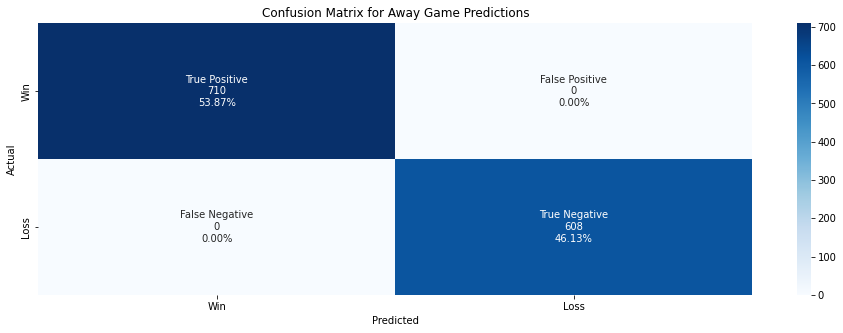

In [11]:
classification_df# Assessing Output Predictions

away_conf_matrix = confusion_matrix(categorical_df['away_outcome'], categorical_df['predicted_away_outcome'])
home_conf_matrix = confusion_matrix(categorical_df['home_outcome'], categorical_df['predicted_home_outcome'])

plt.figure(figsize=(16, 5))

def matrix_plot_labels(matrix):
    group_names = ['True Positive', 'False Positive', 'False Negative', 'True Negative']

    counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]
    percentage = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]

    labels = [f"{i}\n{j}\n{k}" for i, j, k in zip(group_names, counts, percentage)]
    labels = np.asarray(labels).reshape(2,2)

    return labels

ax = sns.heatmap(away_conf_matrix, annot=matrix_plot_labels(away_conf_matrix), cmap='Blues', fmt='')
ax.set_title('Confusion Matrix for Away Game Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Win', 'Loss'])
ax.yaxis.set_ticklabels(['Win', 'Loss'])

plt.savefig('../../images/final_confusion_matrix_away.png')

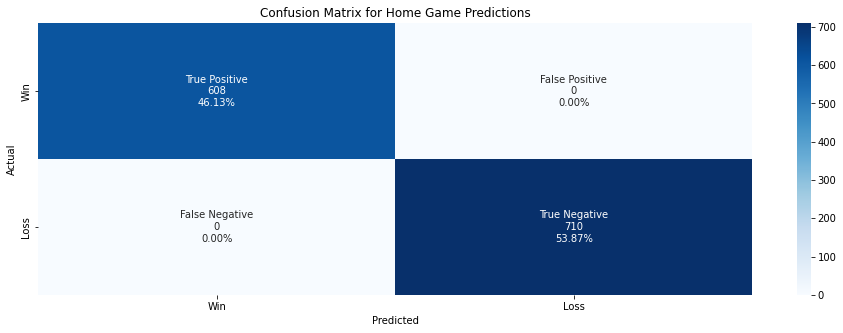

In [12]:
plt.figure(figsize=(16, 5))
ax = sns.heatmap(home_conf_matrix, annot=matrix_plot_labels(home_conf_matrix), cmap='Blues', fmt='')
ax.set_title('Confusion Matrix for Home Game Predictions')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.xaxis.set_ticklabels(['Win', 'Loss'])
ax.yaxis.set_ticklabels(['Win', 'Loss'])

plt.savefig('../../images/final_confusion_matrix_home.png')

# Evaluation

In summary, the models are slightly better in performance but cannot be entirely trusted. The stacked Linear SVM algorithm on top of the ensemble did not have valuable performance detecting true losses or wins, and is fairly even with its overall performance giving around 50% accuracy presumably.

>For insight, we can compare this in a tabular format:


In [13]:
## TODO: Map the values predicted on the classification data to the data with team names

preds_df = categorical_df[['date', 'away_team', 'home_team', 'predicted_away_outcome', 'predicted_home_outcome', 'away_outcome', 'home_outcome']].rename(columns={'away_outcome': 'away_result', 'home_outcome': 'home_result'})
preds_df.predicted_away_outcome = preds_df.predicted_away_outcome.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.predicted_home_outcome = preds_df.predicted_home_outcome.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.home_result = preds_df.home_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
preds_df.away_result = preds_df.away_result.apply(lambda x: 'Win' if x == 1 else 'Loss')
                             
preds_df

,date,away_team,home_team,predicted_away_outcome,predicted_home_outcome,away_result,home_result
0,2021-10-12,Pittsburgh Penguins,Tampa Bay Lightning,Win,Loss,Win,Loss
1,2021-10-12,Seattle Kraken,Vegas Golden Knights,Loss,Win,Loss,Win
2,2021-10-13,Winnipeg Jets,Anaheim Ducks,Loss,Win,Loss,Win
3,2021-10-13,Chicago Blackhawks,Colorado Avalanche,Loss,Win,Loss,Win
4,2021-10-13,Vancouver Canucks,Edmonton Oilers,Loss,Win,Loss,Win
...,...,...,...,...,...,...,...
1313,2022-06-18,Tampa Bay Lightning,Colorado Avalanche,Loss,Win,Loss,Win
1314,2022-06-20,Colorado Avalanche,Tampa Bay Lightning,Loss,Win,Loss,Win
1315,2022-06-22,Colorado Avalanche,Tampa Bay Lightning,Loss,Win,Loss,Win
1316,2022-06-24,Tampa Bay Lightning,Colorado Avalanche,Loss,Win,Loss,Win


Given the predictions favor an away win, this can predict if the away team will win a game or not. This is because we can use an _unbiased_ prediction without home field advantage. 

... For fun, I'm an Avs fan. Let's see how that panned out 

In [14]:
def evaluate_predictions(subset: pd.DataFrame(), correct: int, incorrect: int):

    try :
        print({
            'Correct Predictions': correct, 
            'Incorrect Predictions': incorrect, 
            'Overall Correct': f'{((correct) / (correct + incorrect) * 100)}%'
        
        })
    except Exception as e:
         print(f"{e}")

    return
      
avs_away_games = preds_df[preds_df['away_team']=='Colorado Avalanche']
avscorrect = len(avs_away_games[avs_away_games.predicted_away_outcome == avs_away_games.away_result]) # accurate predictions
avsincorrect = len(avs_away_games[avs_away_games.predicted_away_outcome != avs_away_games.away_result]) # innaccurate predictions

avs_home_games = preds_df[preds_df['home_team']=='Colorado Avalanche']
avs_home_correct = len(avs_home_games[avs_home_games.predicted_home_outcome == avs_home_games.home_result]) # accurate predictions
avs_home_incorrect = len(avs_home_games[avs_home_games.predicted_home_outcome != avs_home_games.home_result]) # innaccurate predictions

away_correct = len(preds_df[preds_df.predicted_away_outcome == preds_df.away_result]) # accurate predictions
away_incorrect = len(preds_df[preds_df.predicted_away_outcome != preds_df.away_result]) # innaccurate predictions

home_correct = len(preds_df[preds_df.predicted_home_outcome == preds_df.home_result]) # accurate predictions
home_incorrect = len(preds_df[preds_df.predicted_home_outcome != preds_df.home_result]) # innaccurate predictions

In [15]:
# Avalanche Away Games 

evaluate_predictions(avs_away_games, avscorrect, avsincorrect)

{'Correct Predictions': 44, 'Incorrect Predictions': 0, 'Overall Correct': '100.0%'}


In [16]:
# Avalanche Home Games 

evaluate_predictions(avs_home_games, avs_home_correct, avs_home_incorrect)

{'Correct Predictions': 44, 'Incorrect Predictions': 0, 'Overall Correct': '100.0%'}


In [17]:
# Original Data 

evaluate_predictions(preds_df, away_correct, away_incorrect)
evaluate_predictions(preds_df, home_correct, home_incorrect)

{'Correct Predictions': 1318, 'Incorrect Predictions': 0, 'Overall Correct': '100.0%'}
{'Correct Predictions': 1318, 'Incorrect Predictions': 0, 'Overall Correct': '100.0%'}


## Summary

The model is not as favorable when considering all features but the away and home goals scored, and is at best 55-60% accurate. When matched to the actual data, few predictions are correct. Omitting the goal features made a significantly negative impact on the model. 

Adding goal features and getting rid of home wins allowed the model to perform well and reasonably, without a classification being 100% determined by home wins. Goals are the most reliable variable and should be used as the primary factor of predicting outcome, of course aided by well-rounded team stats. 

In [18]:
stanley_cup = preds_df.sort_values('date', ascending=True).tail(6)
stanley_cup.drop(columns={'away_result', 'home_result'}, inplace=True)

dfi.export(stanley_cup, '../../images/xgb_stanley_cup_predictions.png')
stanley_cup

objc[10209]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x212d47808) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/103.0.5060.114/Libraries/libGLESv2.dylib (0x1061ad3f8). One of the two will be used. Which one is undefined.
[0707/105631.810463:INFO:headless_shell.cc(660)] Written to file /tmp/tmpzr1z8ox8/temp.png.


,date,away_team,home_team,predicted_away_outcome,predicted_home_outcome
1312,2022-06-15,Tampa Bay Lightning,Colorado Avalanche,Loss,Win
1313,2022-06-18,Tampa Bay Lightning,Colorado Avalanche,Loss,Win
1314,2022-06-20,Colorado Avalanche,Tampa Bay Lightning,Loss,Win
1315,2022-06-22,Colorado Avalanche,Tampa Bay Lightning,Loss,Win
1316,2022-06-24,Tampa Bay Lightning,Colorado Avalanche,Loss,Win
1317,2022-06-26,Colorado Avalanche,Tampa Bay Lightning,Loss,Win


In [19]:
# AWAY XGBOOST MODEL 

away = permutation_importance(away_stacked_model, x_away_test, y_away_test,
                           n_repeats=30,
                           random_state=0)
for i in away.importances_mean.argsort()[::-1]:
    if away.importances_mean[i] - 2 * away.importances_std[i] > 0:
        print(f"{classification_df.columns[i]:<8}:\n"
              f"{away.importances_mean[i]:.3f}"
              f" +/- {away.importances_std[i]:.3f}")

## SOURCE https://scikit-learn.org/stable/modules/permutation_importance.html

home_goals:
0.312 +/- 0.020
away_goals:
0.307 +/- 0.017
GDIFF   :
0.009 +/- 0.004


In [21]:
# HOME XGBOOST MODEL 

home = permutation_importance(home_stacked_model, x_home_test, y_home_test,
                           n_repeats=30,
                           random_state=0)
for i in home.importances_mean.argsort()[::-1]:
    if home.importances_mean[i] - 2 * home.importances_std[i] > 0:
        print(f"{classification_df.columns[i]:<8}:\n"
              f"{home.importances_mean[i]:.3f}"
              f" +/- {home.importances_std[i]:.3f}")


home_goals:
0.312 +/- 0.020
away_goals:
0.307 +/- 0.017
GDIFF   :
0.009 +/- 0.004


Goals are the determinant factors in the process for both away and home game data